In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import pickle
import difflib
from collections import Counter

%matplotlib inline
from keras.utils import np_utils

train = pd.read_csv('../train.csv', sep=',', header=0)
#test = pd.read_csv('../test.csv', sep=',', header=0)

train = train.fillna(" ")
#test = test.fillna(" ")
print(train.shape)

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer 
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import log_loss



train.head(2)

/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using TensorFlow backend.


(404290, 6)
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/timomoeller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/timomoeller/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [3]:
def upsampleNegativesCreative(train):
    labels = train.is_duplicate.values
    negs = np.sum(labels == 0)
    pos = np.sum(labels == 1)
    negIncrease = int(pos / 0.165) - negs

    idxLeft = np.random.randint(low=0,high=train.shape[0],size=negIncrease)
    idxRight = np.random.randint(low=0,high=train.shape[0],size=negIncrease)

    dfLeft = train.loc[idxLeft,["qid1","question1"]].copy()
    dfLeft = dfLeft.set_index(pd.Series(range(dfLeft.shape[0])))
    dfRight = train.loc[idxRight,["qid2","question2"]].copy()
    dfRight = dfRight.set_index(pd.Series(range(dfRight.shape[0])))
    dfRest = pd.DataFrame({'id':[-1]*negIncrease,
                           'is_duplicate' : [0] * negIncrease})
    append = pd.concat([dfLeft,dfRight,dfRest],axis=1)
    df = pd.concat([train,append],axis=0)
    return df

train = upsampleNegativesCreative(train)
print(train.shape)

(1053887, 6)


In [6]:
stop_words = set(stopwords.words('english'))

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 1),min_df=4)
tfidf.fit(np.concatenate([train["question1"].values,train["question2"].values],axis=0))

def sequence_match(st1, st2):
    seq = difflib.SequenceMatcher()
    seq.set_seqs(str(st1).lower(), str(st2).lower())
    return seq.ratio()

#gets a pandas row with specific column names!
def noun_match_ratio(row):
    if(row.z_noun_match == 0): 
        return 0
    else:
        return row.z_noun_match / ((len(row.question1_nouns)+len(row.question2_nouns))/2)

def noun_extracter(sentence):
    tokens = nltk.word_tokenize(sentence.lower())
    return np.array([w for w, t in nltk.pos_tag(tokens) if t[:1] in ['N']])
    
def word_match(q1,q2):
    q1 = q1.split()
    q2 = q2.split()
    if(len(q1) == 0 or len(q2) == 0):
        return 0
    else:
        both = set(q1).intersection(set(q2))
        return len(both) * 2 / (len(q1) + len(q2))
    
def removePunktAndStopwords(phrases):
    toInclude = set(['above','below','between','but','couldn','didn','doesn','down',
                     'few','hadn','haven','isn','just','mightn','mustn','needn','nor',
                     'not','off','once','only','out','over','should','shouldn','some',
                     'very','wasn','weren','won','wouldn','again','against','all',
                     'any','aren'])
    stop_wordsLarge = set(stopwords.words('english'))
    stop_words = set(stopwords.words('english'))#set([w for w in stop_wordsLarge if w not in toInclude])
    tokenizer = RegexpTokenizer('[a-z]\w+')
    docs_toke = [tokenizer.tokenize(doc.lower()) for doc in phrases]
    stopwordsremoved = [[t for t in temp if t not in stop_words] for temp in docs_toke]
    return np.asarray([" ".join(w) for w in stopwordsremoved])

def stopWordsRemover(phrase):
    bla = [w for w in str(phrase).lower().split() if w not in stop_words]
    return " ".join(bla)

import re

class LemmaTokenizer(object):
    def __init__(self):
        self.snbstem = SnowballStemmer('english')
    def lemmatizeWithoutPunkt(self,doc):
        doc = re.sub('[?.,!():]',"",doc)
        temp = [self.snbstem.stem(t) for t in doc.lower().split()]
        return " ".join(temp)
    

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stop_words:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stop_words:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R


In [5]:
def getFeatures(df):
    questions1 = df["question1"].values
    questions2 = df["question2"].values
    df.loc[:,"q1sW"] = df.apply(lambda x: stopWordsRemover(x.question1),axis=1)
    df.loc[:,"q2sW"] = df.apply(lambda x: stopWordsRemover(x.question2),axis=1)
    df = df.assign(question1_nouns=pd.Series(Parallel(n_jobs=5)(delayed(noun_extracter)(x) for x in questions1)))
    df = df.assign(question2_nouns=pd.Series(Parallel(n_jobs=5)(delayed(noun_extracter)(x) for x in questions2)))
    df.loc[:,'z_len1'] = df.question1.map(lambda x: len(str(x)))
    df.loc[:,'z_len2'] = df.question2.map(lambda x: len(str(x)))
    df.loc[:,'z_word_len1'] = df.question1.map(lambda x: len(str(x).split()))
    df.loc[:,'z_word_len2'] = df.question2.map(lambda x: len(str(x).split()))
    df.loc[:,'z_noun_match'] = df.apply(lambda r: sum([1 for w in r["question1_nouns"] if w in r["question2_nouns"]]), axis=1) 
    df.loc[:,'z_noun_match_ratio'] = df.apply(lambda r: noun_match_ratio(r), axis=1)
    df = df.assign(z_sequence_match=pd.Series(Parallel(n_jobs=7)
                                       (delayed(sequence_match)(x,y) for x,y in zip(df["q1sW"].values,df["q2sW"].values))))
    df = df.assign(z_word_match=pd.Series(Parallel(n_jobs=7)
                                      (delayed(word_match)(x,y) for x,y in zip(df["q1sW"].values,df["q2sW"].values))))
    
    preprocessor = LemmaTokenizer()
    df = df.assign(q1_stemmed=pd.Series(Parallel(n_jobs=7)(delayed(
                    preprocessor.lemmatizeWithoutPunkt)(sentence) for sentence in df.question1.values)))
    df = df.assign(q2_stemmed=pd.Series(Parallel(n_jobs=7)(delayed(
                preprocessor.lemmatizeWithoutPunkt)(sentence) for sentence in df.question2.values)))
    
    tfidfQ1 = tfidf.transform(df["question1"])
    tfidfQ2 = tfidf.transform(df["question2"])
    df.loc[:,'z_tfidf_sum1'] = pd.Series(np.squeeze(np.asarray(tfidfQ1.sum(axis=1))))
    df.loc[:,'z_tfidf_sum2'] = pd.Series(np.squeeze(np.asarray(tfidfQ2.sum(axis=1))))
    df.loc[:,'z_tfidf_mean1'] = pd.Series(np.squeeze(np.asarray(tfidfQ1.mean(axis=1))))
    df.loc[:,'z_tfidf_mean2'] = pd.Series(np.squeeze(np.asarray(tfidfQ2.mean(axis=1))))
    
    return df
    

train = getFeatures(train)

#pickle.dump(train,open("dumps/trainFeatures04-15.p", "wb" ))
col = [c for c in train.columns if c[:1]=='z']

#dump explanations
# xFeatures04-10: until tfidf mean


/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [ ]:
import pickle
train = pickle.load(open("dumps/trainFeatures04-10.p", "rb" ))
test = pickle.load(open("dumps/testFeatures04-10.p", "rb" ))
col = [c for c in train.columns if c[:2]=='z_']

In [10]:
def addfeature(df):
    preprocessor = LemmaTokenizer()
    df = df.assign(q1_stemmed=pd.Series(Parallel(n_jobs=7)(delayed(
                    preprocessor.lemmatizeWithoutPunkt)(sentence) for sentence in df.question1.values)))
    df = df.assign(q2_stemmed=pd.Series(Parallel(n_jobs=7)(delayed(
                preprocessor.lemmatizeWithoutPunkt)(sentence) for sentence in df.question2.values)))
    
    return df
    
test = addfeature(test)

In [11]:
pickle.dump(test,open("dumps/testFeatures04-10.p", "wb" ))

In [7]:
def upsampleNegatives(X,y):
    negs = np.sum(y == 0)
    pos = np.sum(y == 1)
    negIncrease = int(pos / 0.165) - negs
    negidx= np.nonzero(y == 0)[0]
    idx = np.random.randint(low=0,high=negidx.shape[0],size=negIncrease)
    Xnew = np.concatenate([X,X[negidx[idx]]])
    ynew = np.concatenate([y,y[negidx[idx]]])
    return Xnew, ynew

X_train, X_test, y_train, y_test = train_test_split(train[col].values, train["is_duplicate"].values, test_size=0.2)
X2,y2 = upsampleNegatives(X_test,y_test)
X1,y1 = upsampleNegatives(X_train,y_train)

In [10]:
# xgb api with additional methods and params 

X_train, X_test, y_train, y_test = train_test_split(train[col].values, train["is_duplicate"].values, test_size=0.2)

# num_testing = 100000
# X_train = train[col].values[num_testing:]
# X_test = train[col].values[:num_testing]
# y_train = train["is_duplicate"].values[num_testing:]
# y_test = train["is_duplicate"].values[:num_testing]
# # classification

Dtrain = xgb.DMatrix(X_train,y_train,feature_names=col)

Dvalid = xgb.DMatrix(X_test,y_test,feature_names=col) 
#Dtrain = xgb.DMatrix(X1,y1,feature_names=col) 
#Dvalid = xgb.DMatrix(X2,y2,feature_names=col)

params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params["max_depth"] = 6
params["scale_pos_weight"] = np.sum(y_train == 0) / np.sum(y_train == 1)
#taking fancy params from matching que for quora gives ~0.02 worse valid logloss and kaggle result

watchlist = [(Dtrain,"train"),(Dvalid,"valid")]

bst = xgb.train(params, Dtrain, 200, watchlist, early_stopping_rounds=20, verbose_eval=10)
#pickle.dump(bst,open("xgb.p","wb"))

#Testing different settings: depth 6 for all, valid logloss displayed
#log_loss(train.is_duplicate.values,[0.37]*train.shape[0]) = 0.6585
# normal no upsampling 0.421217
# upsampling everything, train and test: 0.28344: after round ~130 no improvement. BUT on kaggle: 0.34
# !!!!!upsampling only test set: round 1590: 0.255242 still decreasing. BUT on Kaggle: 0.40

[0]	train-logloss:0.584069	valid-logloss:0.584546
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.412249	valid-logloss:0.414844
[20]	train-logloss:0.385598	valid-logloss:0.388987
[30]	train-logloss:0.371326	valid-logloss:0.375568
[40]	train-logloss:0.360291	valid-logloss:0.365487
[50]	train-logloss:0.353316	valid-logloss:0.359142
[60]	train-logloss:0.348728	valid-logloss:0.35516
[70]	train-logloss:0.345811	valid-logloss:0.352785
[80]	train-logloss:0.34191	valid-logloss:0.34956
[90]	train-logloss:0.339954	valid-logloss:0.348099
[100]	train-logloss:0.337311	valid-logloss:0.345982
[110]	train-logloss:0.334295	valid-logloss:0.343629
[120]	train-logloss:0.331787	valid-logloss:0.341849
[130]	train-logloss:0.330085	valid-logloss:0.34063
[140]	train-logloss:0.328659	valid-logloss:0.339755
[150]	train-logloss:0.32723	valid-logloss:0.338924
[160]	train-logloss:0.325132	vali

In [13]:
#add countvec and use xgb cv!
ctv = CountVectorizer(min_df=50,binary=True)
ctv.fit(np.concatenate([train.q1_stemmed.values,train.q2_stemmed.values],axis=0))
len(ctv.get_feature_names())
q1bow = ctv.transform(train.q1_stemmed.values)
q2bow = ctv.transform(train.q2_stemmed.values)
together = q1bow + q2bow


In [ ]:
############### FIRST use xgb.cv for param tuning on data
features = sp.sparse.hstack([sp.sparse.csr_matrix(train[col].values),together])
feature_names = np.concatenate([col,ctv.get_feature_names()])
Dtrain = xgb.DMatrix(features,train.is_duplicate.values,feature_names=feature_names)

params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss' #'logloss'
params["max_depth"] = 12
params["eta"] = 0.5 #learning rate defaults 0.3
#params["gamma"] = 1 # regularization multiplier, default 1
params["min_child_weight"] = 0.8 #reg param controlling 2nd derivative impact default 1

bst = xgb.cv(params, Dtrain, 300, nfold=4, early_stopping_rounds=20, verbose_eval=10)


In [ ]:
############### SECOND make train valid set and train 1 booster with settings from above
features = sp.sparse.hstack([sp.sparse.csr_matrix(train[col].values),together])
feature_names = np.concatenate([col,ctv.get_feature_names()])

X_train, X_test, y_train, y_test = train_test_split(features, train["is_duplicate"].values, test_size=0.2)
Dtrain = xgb.DMatrix(X_train,y_train,feature_names=feature_names)
Dvalid = xgb.DMatrix(X_test,y_test,feature_names=feature_names) 

params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params["max_depth"] = 12
params["eta"] = 0.5 
params["min_child_weight"] = 0.8 


watchlist = [(Dtrain,"train"),(Dvalid,"valid")]
bst = xgb.train(params, Dtrain, 300, watchlist, early_stopping_rounds=20, verbose_eval=10)

In [31]:
########### THIRD get test set features, predict, convert to 0.165, sanity check and submit

def convertPredictions(preds):
    a = 0.165 / 0.37 
    b = (1 - 0.165) / (1 - 0.37)

    return (preds * a)  / (preds * a + (1 - preds) * b)


test = pickle.load(open("dumps/testFeatures04-10.p", "rb" ))
q1bow = ctv.transform(test.q1_stemmed.values)
q2bow = ctv.transform(test.q2_stemmed.values)
together = q1bow + q2bow
features = sp.sparse.hstack([sp.sparse.csr_matrix(test[col].values),together])
feature_names = np.concatenate([col,ctv.get_feature_names()])
Dtest = xgb.DMatrix(features,feature_names=feature_names)

preds = bst.predict(Dtest)
preds = convertPredictions(preds)

plt.figure()
plt.hist(preds,40)
plt.show()

test = pickle.load(open("dumps/testFeatures04-10.p", "rb" ))
test["is_duplicate"] = pd.Series(preds,index=test.index)
header = ["test_id", "is_duplicate"]
test.to_csv('../submissions/predictions.csv', columns = header,index=False)

In [18]:
from xgboost import plot_tree
%matplotlib 
plot_tree(bst,num_trees=4)

Using matplotlib backend: TkAgg


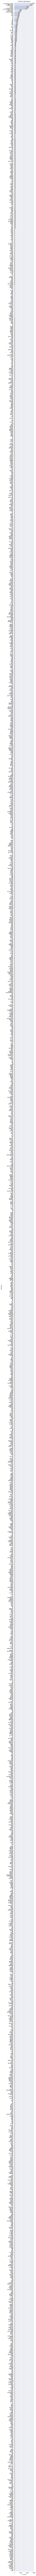

In [36]:
# I don't understand this. with fancy settings from "matching que for quora" the ratings make sense
# just using standard settings, stupid featlengths and tfidf sums 
plt.rcParams['figure.figsize'] = (3, 400.0)
xgb.plot_importance(bst); plt.show()